In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import calendar
from sklearn.linear_model import LinearRegression
import json

# P2

In this milestone, our focus is on movies and their sequels, as well as movies without sequels. The initial step involves data preprocessing to facilitate subsequent analysis.

## Data collection

To actually carry out our project idea, we needed to obtain one extra information, which is not given in our initial dataset: _does a movie have a sequel?_

We extracted the missing information regarding movie sequels by web scraping from Wikipedia and Wikidata. Indeed, Wikidata has a specific section dedicated to this, as can be seen in the image here-under. 

<div>
<img src="./sequel_scraper/wikidata_sequel_info.png" width="700"/>
</div>



The code used for this is in the file "wiki_scraper.py" which can be found under ./sequel_scraper. 

Here's a recap of the what the code does:

Data Loading:
The code starts by importing necessary libraries, such as pandas for data manipulation, requests for making HTTP requests, and BeautifulSoup for web scraping.
The movie metadata is loaded from a TSV file into a Pandas DataFrame. 

Two functions are defined for web scraping:
extract_ID: Extracts the Wikidata ID from a given string.
scrape_wikidata_id: Scrapes the Wikidata ID for a given movie from its Wikipedia page.
scrape_sequels: Scrapes the prequel and sequel IDs for a given movie from its Wikidata page.

Scraping Loop:
A new Pandas DataFrame named online_scraping is created with columns 'WikipediaID', 'WikidataID', 'PrequelID', and 'SequelID' to store the scraping results.
A loop iterates over the dataframe, calling the scrape_wikidata_id and scrape_sequels functions to extract Wikidata and sequel information for each movie.
The results are stored in the online_scraping DataFrame.

Output:
The scraping results are saved to a CSV file named 'sequels.csv'. The CSV file includes columns for WikipediaID, WikidataID, PrequelID, and SequelID.


## Some initial dataframes

For reference, here are the naming conventions used:
- An _original_ movie is a movie that has a sequel

The file *sequels.csv* contains 4 columns : 
- WikipediaID : ID from wikipedia
- WikidataID : ID from wikidata
- PrequelID : ID of the prequel from wikidata (nan when there is no prequel) 
- SequelID : ID of the sequel from wikidata (nan when there is no sequel) 

In [2]:
from_csv = pd.read_csv("sequels.csv")
orignals_sequels = from_csv[['WikipediaID', 'WikidataID', 'SequelID']].dropna(subset=['SequelID']) #We only keep the movies with a sequel

In [3]:
#Now we need to only keep original films that are in the CMU dataset
cmu_movies = pd.read_csv("movie_summaries/movie.metadata.tsv", sep="\t", names = ['WikipediaID', 'FreebaseID', 'MovieName', 'ReleaseDate', 'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

 Before moving on to the next phase, we encountered some errors while exploring the data. Since these errors are not frequent, we have opted to address them manually and make the necessary updates.

### Error corrections

**Zero Tolerance** has a runtime of 1079281 minutes which is false when looking up on the [wikipedia page](https://en.wikipedia.org/wiki/Zero_Tolerance_(1994_film)), the true value is 94 minutes. 

**Hunting Season** has 1010 as the released year, which is also a mistake when looking at the [wikipedia page](https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)), the true year of released is 2010. 

In [4]:
cmu_movies.at[12804,'Runtime'] = 94.0 # Fixing runtime for Zero Tolerance
cmu_movies.at[62836,'ReleaseDate'] = '2010-12-02' # Fixing date for Hunting Season

In [5]:
df_has_sequels = cmu_movies[cmu_movies['WikipediaID'].isin(orignals_sequels['WikipediaID'])] #Dataframe with only movies that have a sequel
df_no_sequels = cmu_movies[~cmu_movies['WikipediaID'].isin(orignals_sequels['WikipediaID'])] #Dataframe with only movies that don't have a sequel

In [6]:
percentage_with_sequels = len(df_has_sequels)/len(cmu_movies)
print(f'Percentage of films with a sequel : {percentage_with_sequels:.2f}')

Percentage of films with a sequel : 0.05


So, only about 5% of movies have a sequel, which isn't much in our dataset. Our objective is to comprehend the distinctions among this subset of films, those without a sequel, and compare them against the overall dataset statistics.



## Part 1: Comparing movies with sequels and movies with no sequels

We will begin by doing some initial comparaison on : 
* Earnings
* Duration
* Month of release
* Year of release
* Country of origin
* Film genre
* Characters
    * Age
    * Gender

### Earnings

Our initial approach involves creating a plot to compare the revenues of movies with sequels to those without sequels. This graphical representation will serve as an initial exploration into the potential differences in revenue between these two categories.

In [7]:
with_sequels_earnings = df_has_sequels.dropna(subset=['BoxOffice'])
no_sequels_earnings = df_no_sequels.dropna(subset=['BoxOffice'])

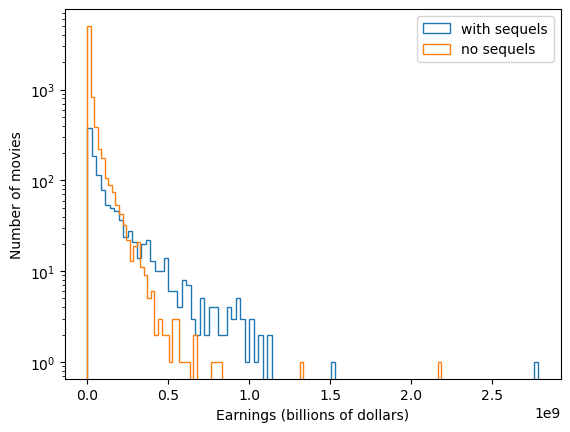

In [8]:
# Plot the earnings of movies with sequels and those without sequels using a histogram with a logarithmic scale on the y-axis.

n_bins = 100
plt.hist(with_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Earnings (billions of dollars)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

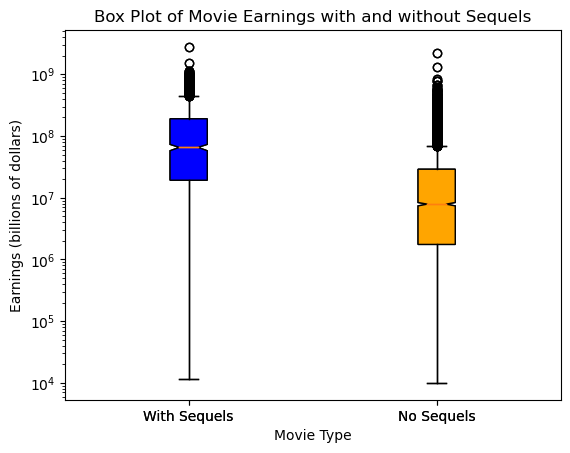

In [9]:
# For better vizualisation, we plot the Box Plot of earnings of movies with sequels and those without sequels

# Combine the earnings data into a list for box plot creation
earnings_data = [with_sequels_earnings['BoxOffice'], no_sequels_earnings['BoxOffice']]

# Create a box plot
plt.boxplot(earnings_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Earnings (billions of dollars)')
plt.title('Box Plot of Movie Earnings with and without Sequels')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(earnings_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()


At quick glance, it seems like movies with sequels rake in more money than those without. But hold on, a bunch of the data is missing!

In [10]:
print(f'Percentage of movies with sequels that has the revenue in the dataset : {len(with_sequels_earnings)/ len(df_has_sequels):.2f}')
print(f'Percentage of movies with no sequels that has the revenue in the dataset : {len(no_sequels_earnings)/ len(df_no_sequels):.2f}')

Percentage of movies with sequels that has the revenue in the dataset : 0.31
Percentage of movies with no sequels that has the revenue in the dataset : 0.09


Only 31% and 9% of the data repespectively is present. We need a deeper analysis to confirm that movies with sequels are movies that tend to generate more money.

In [11]:
from scipy.stats import ttest_ind

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(with_sequels_earnings['BoxOffice'], no_sequels_earnings['BoxOffice'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in earnings between movies with sequels and without sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in earnings between movies with sequels and without sequels.')


T-test Statistic: 18.76842645919925
P-value: 2.1795476437484413e-69
Reject the null hypothesis: There is a significant difference in earnings between movies with sequels and without sequels.


### Duration 

In [12]:
with_sequels_duration = df_has_sequels.dropna(subset=['Runtime'])
no_sequels_duration = df_no_sequels.dropna(subset=['Runtime'])

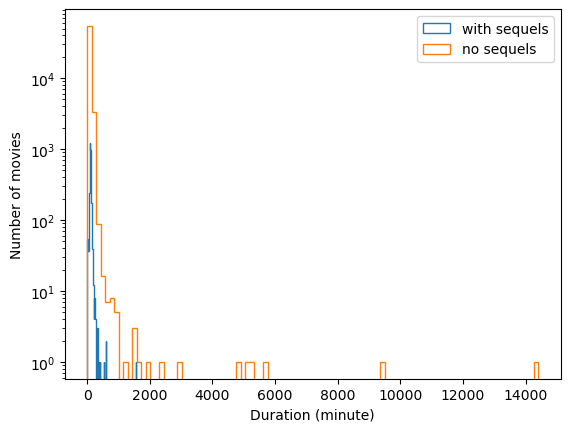

In [13]:
# Plot the duration of movies with sequels and those without sequels using a histogram with a logarithmic scale on the y-axis.

n_bins = 100
plt.hist(with_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Duration (minute)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

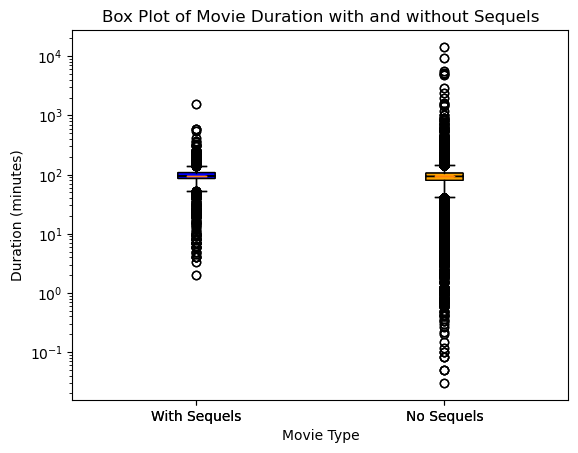

In [14]:
# Combine the duration data into a list for box plot creation
duration_data = [with_sequels_duration['Runtime'], no_sequels_duration['Runtime']]

# Create a box plot
plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Duration (minutes)')
plt.title('Box Plot of Movie Duration with and without Sequels')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()


Let's look at the data for both categories more closely and get some numbers.

In [15]:
no_sequels_duration['Runtime'].describe()

count    57865.000000
mean        93.962255
std         93.391836
min          0.000000
25%         80.000000
50%         93.000000
75%        106.000000
max      14400.000000
Name: Runtime, dtype: float64

In [16]:
with_sequels_duration['Runtime'].describe()

count    3426.000000
mean       98.422834
std        42.194757
min         2.000000
25%        86.000000
50%        95.000000
75%       108.000000
max      1560.000000
Name: Runtime, dtype: float64

We have identified outliers in our data, which contains both very long and very short movies. Upon further investigation, we've uncovered a new category of movies that wasn't initially considered. Let's see what our longest movie is.

In [17]:
no_sequels_duration[no_sequels_duration['Runtime'] == no_sequels_duration['Runtime'].max()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}"


In our investigation of this movie, we came across this [wikipedia page](https://en.wikipedia.org/wiki/List_of_longest_films), specifically dedicated to the longest films. However, this category poses challenges for standard plotting. Additionally, it's worth noting that certain entries, like Swallow the Sun, may not fit the conventional definition of a movie, as it is a Korean drama spanning 25 episodes.

At the same time, our dataset contains very short movies. Let's learn more about the shortest.

In [18]:
no_sequels_duration[no_sequels_duration['Runtime'] == no_sequels_duration['Runtime'].min()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,1894,NaN,0.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"


As usual, we turned to Wikipedia to help with our investigation. On the [dedicated wikipedia page](https://fr.wikipedia.org/wiki/Dickson_Experimental_Sound_Film), we can see that our shortest movie is The "Dickson Experimental Sound Film", which is an early attempt at synchronized sound and motion pictures, featuring Dickson playing the violin while two men dance. The movie only lasts 17 seconds.

We are now aware that our data contains movies that do not necessarily fit our definition in terms of duration, either because they are too long or too short. For that, we need a more precise definition in terms of duration, which will be our base for filtering out outliers. Hence, we need to define a minimum and maximum duration for our movies before we continue our analysis. We came across the notion of a [feature film](https://en.wikipedia.org/wiki/Feature_film), which seems to be more consistent with our vision when we deciced to conduct this analysis.

For a more rigourous definition, we can turn to people who are a bit more cinephile than us. For example, in the same page, we learned that the Academy of Motion Picture Arts and Sciences, the American Film Institute and the British Film Institute all agree to set the minimum duration for a feature film to 40 minutes. We did not come across a maximum duration, but we decided that movies in our dataset should not be longer than 5 hours, or 300 minutes. Let's see the percentage of movies that fit into this definition in our two categories.

In [19]:
# filter to only keep movies that fit into this new definition

filtered_with_sequels_duration = with_sequels_duration[(with_sequels_duration['Runtime'] >= 40) & (with_sequels_duration['Runtime'] < 300)]
filtered_no_sequels_duration = no_sequels_duration[(no_sequels_duration['Runtime'] >= 40) & (no_sequels_duration['Runtime'] < 300)]

In [20]:
# compute percentage of movies that fit into this new definition

print(f'Percentage of movies with sequels with length between 40 minutes and 300 minutes in the dataset : {len(filtered_with_sequels_duration)/ len(with_sequels_duration):.2f}')
print(f'Percentage of movies with no sequels with length between 40 minutes and 300 minutes in the dataset : {len(filtered_no_sequels_duration)/ len(no_sequels_duration):.2f}')

Percentage of movies with sequels with length between 40 minutes and 300 minutes in the dataset : 0.96
Percentage of movies with no sequels with length between 40 minutes and 300 minutes in the dataset : 0.92


We can see that after filtering "outliers" in both categories, we still get to keep 96% of movies with sequels and 92% of movies with no sequels. Let's now plot the Box Plot again to get a better grasp of the distribution of the duration of our filtered movies. 

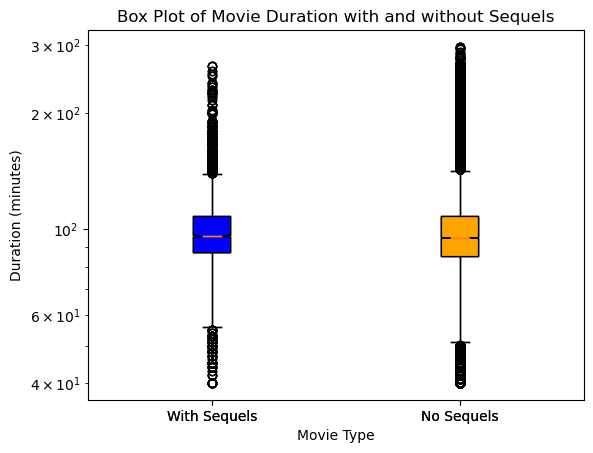

In [21]:
# Combine the duration data into a list for box plot creation
duration_data = [filtered_with_sequels_duration['Runtime'], filtered_no_sequels_duration['Runtime']]

# Create a box plot
plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Duration (minutes)')
plt.title('Box Plot of Movie Duration with and without Sequels')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()

Let's perform a t-test to see if there is a significant difference in the mean of the duration of feature films with sequels and feature films without sequels.

In [22]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(filtered_with_sequels_duration['Runtime'], filtered_no_sequels_duration['Runtime'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in duration between (filtered) movies with sequels and without sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in duration between (filtered) movies with sequels and without sequels.')


T-test Statistic: 2.6466075005227463
P-value: 0.008164120246546143
Reject the null hypothesis: There is a significant difference in duration between (filtered) movies with sequels and without sequels.


### Month of release

Some of the dates are just years, our initial task would be to extract the month from those that include a month.

In [23]:
# Extract the month from the ReleaseDate column for movies with and without sequels
df_has_sequels.loc[:,'Month'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month
df_no_sequels.loc[:,'Month'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month

# Drop rows with missing month data for movies with and without sequels
with_sequels_months = df_has_sequels.dropna(subset=['Month'])
no_sequels_months = df_no_sequels.dropna(subset=['Month'])

/tmp/ipykernel_817/3794036586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_has_sequels.loc[:,'Month'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month
/tmp/ipykernel_817/3794036586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_sequels.loc[:,'Month'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month


In [24]:
count_months_sequels = with_sequels_months.groupby('Month')['Month'].sum()
count_months_no_sequels = no_sequels_months.groupby('Month')['Month'].sum()

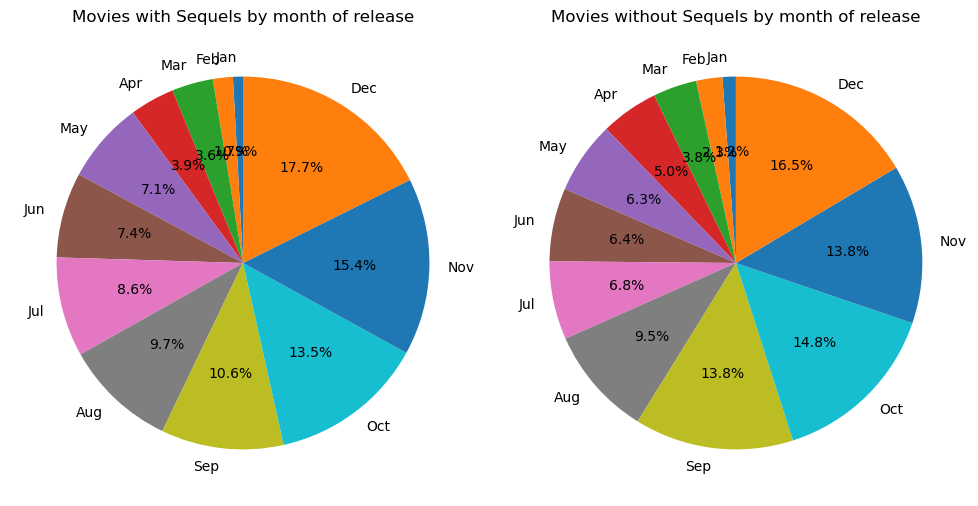

In [25]:
months = list(map(lambda x: calendar.month_abbr[x], np.arange(1,13)))

# Calculate percentages
percent_sequels = count_months_sequels / count_months_sequels.sum() * 100
percent_no_sequels = count_months_no_sequels / count_months_no_sequels.sum() * 100

# Plot pie chart for movies with sequels
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(percent_sequels, labels=months, autopct='%1.1f%%', startangle=90)
plt.title('Movies with Sequels by month of release')

# Plot pie chart for movies without sequels
plt.subplot(1, 2, 2)
plt.pie(percent_no_sequels, labels=months, autopct='%1.1f%%', startangle=90)
plt.title('Movies without Sequels by month of release')

plt.tight_layout()
plt.show()


### Year of release

In [26]:
# Extract the year from the ReleaseDate column for movies with and without sequels
df_has_sequels.loc[:,'Year'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='mixed').dt.year
df_no_sequels.loc[:,'Year'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='mixed').dt.year

# Extract the year from the dataset, will be useful later
cmu_movies.loc[:,'Year'] = pd.to_datetime(cmu_movies['ReleaseDate'], format='mixed').dt.year
movie_per_year = cmu_movies.groupby('Year')['Year'].count()

# Drop rows with missing year data for movies with and without sequels
with_sequels_year = df_has_sequels.dropna(subset=['Year'])
no_sequels_year = df_no_sequels.dropna(subset=['Year'])

/tmp/ipykernel_817/3131206138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_has_sequels.loc[:,'Year'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='mixed').dt.year
/tmp/ipykernel_817/3131206138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_sequels.loc[:,'Year'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='mixed').dt.year


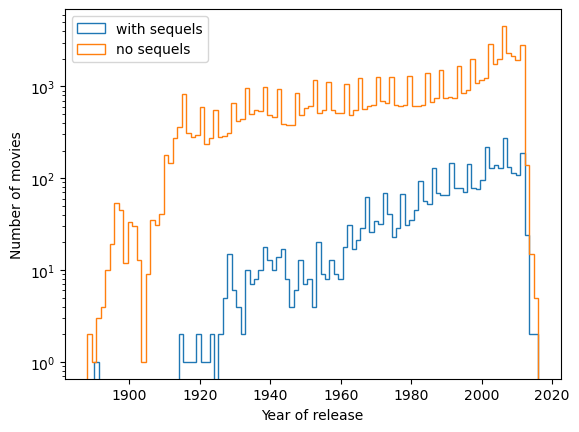

In [27]:
# Plot the year of release of movies with sequels and those without sequels using a histogram with a logarithmic scale on the y-axis.
n_bins = 100
plt.hist(with_sequels_year['Year'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_year['Year'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Year of release')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

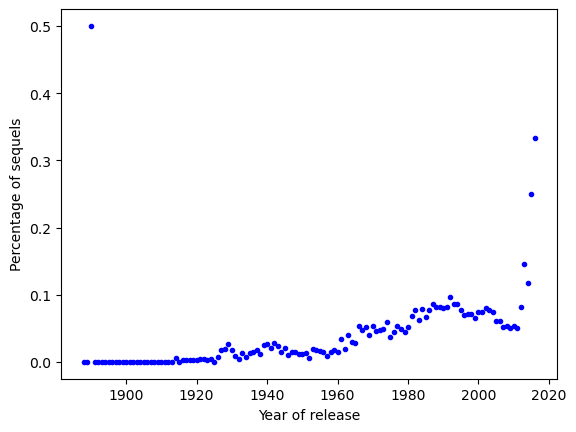

In [28]:
# Plotting the percentage of movies with and without sequels per year
sequels_per_year = with_sequels_year.groupby('Year')['Year'].count()
no_sequels_per_year = no_sequels_year.groupby('Year')['Year'].count()

# Create a new array with data for all years
all_years = np.arange(cmu_movies['Year'].min(), cmu_movies['Year'].max() + 1)

# Fill in missing values with zeros
sequels_per_year = sequels_per_year.reindex(all_years, fill_value=0)
no_sequels_per_year = no_sequels_per_year.reindex(all_years, fill_value=0)

# Plot the percentage of sequels per year
plt.plot(all_years, sequels_per_year/(sequels_per_year + no_sequels_per_year), 'b.')
plt.xlabel('Year of release')
plt.ylabel('Percentage of sequels')
plt.show()

The plot appears to indicate a rising trend, but before delving deeper, let's examine the distribution within our dataset. 

In [29]:
cmu_movies.loc[:,'Year'] = pd.to_datetime(cmu_movies['ReleaseDate'], format='mixed').dt.year
movie_per_year = cmu_movies.groupby('Year')['Year'].count()

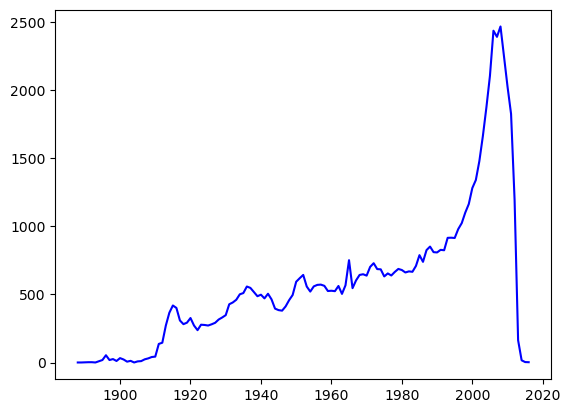

In [30]:
plt.plot(all_years, movie_per_year, 'b-')

It appears that the dataset has fewer entries after the year 2013. Therefore, for a more accurate analysis, we should limit our exploration of trends to data up to the year 2013. Additionally, the year 1890 stands out as an outlier concerning sequels, with only two movies recorded during that year, and one of them being a sequel.

The slope is  : [[0.00076065]]


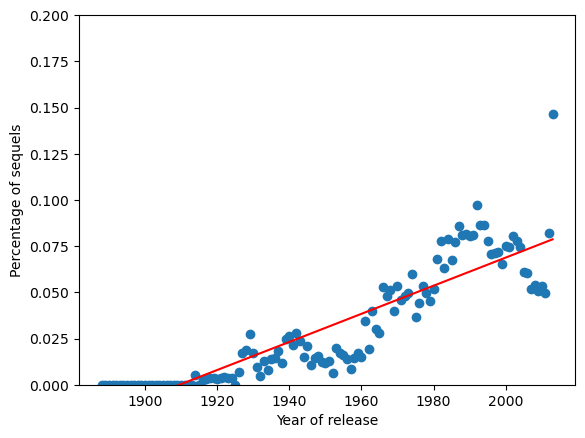

In [31]:
# Plotting the percentage of movies with and without sequels per year
sequels_per_year_b2013 = with_sequels_year[with_sequels_year['Year'] <= 2013].groupby('Year')['Year'].count()
no_sequels_per_year_b2013 = no_sequels_year[no_sequels_year['Year'] <= 2013].groupby('Year')['Year'].count()

# Create a new array with data for all years
all_years_b2013 = np.arange(cmu_movies['Year'].min(), 2014)

# Fill in missing values with zeros
sequels_per_year_b2013 = sequels_per_year_b2013.reindex(all_years_b2013, fill_value=0)
no_sequels_per_year_b2013 = no_sequels_per_year_b2013.reindex(all_years_b2013, fill_value=0)

#Fix outlier
sequels_per_year_b2013.iloc[2] = 0

# Linear regression to interpret the slope of the trend
lr = LinearRegression()
x = all_years_b2013.reshape(-1, 1)
y = (sequels_per_year_b2013/(sequels_per_year_b2013 + no_sequels_per_year_b2013)).values.reshape(-1, 1)
lr.fit(x, y)
y_hat = lr.predict(x)

print(f'The slope is  : {lr.coef_}')

# Plot the percentage of sequels per year
plt.scatter(all_years_b2013, sequels_per_year_b2013/(sequels_per_year_b2013 + no_sequels_per_year_b2013))
plt.plot(all_years_b2013, y_hat, 'r-')
plt.xlabel('Year of release')
plt.ylabel('Percentage of sequels')

#limit plot as we are plotting percentages
plt.ylim(0, 0.20)
plt.show()

By fitting a linear regression to the available data, we observe a positive slope. However, the plot suggests a more sinusoidal trend. It's important to note that attempting to predict future trends with such limited information may not yield meaningful results. The nature of the data, especially if it appears sinusoidal, may require more sophisticated modeling techniques for accurate predictions. 

### Country of Origin

In [32]:
with_sequels_countries = df_has_sequels.dropna(subset=['Countries'])
no_sequels_countries = df_no_sequels.dropna(subset=['Countries'])

Let's randomly pick a movie and see how the countries of origin are represented in the dataset.

In [33]:
print(with_sequels_countries.iloc[42]['Countries'])
print(type(with_sequels_countries.iloc[42]['Countries']))

{"/m/09c7w0": "United States of America"}
<class 'str'>


This representation is not ideal to conduct our analysis, let's switch it for a more efficient one.

In [34]:
def parse_countries(country_str):
    try:
        # Convert the string to a dictionary
        country_dict = json.loads(country_str)

        # Return the list of country names
        return list(country_dict.values())
    except json.JSONDecodeError:
        # In case of parsing error, return an empty list or some default value
        return []

# Update 'Countries' column to contain lists of country names
with_sequels_countries['Countries'] = with_sequels_countries['Countries'].apply(parse_countries)
no_sequels_countries['Countries'] = no_sequels_countries['Countries'].apply(parse_countries)

# Now 'Countries' columns in both DataFrames contain lists of country names


We know that movies can have many countries of origin, combining different regions across the world. Let's take a closer look at the distribution.

In [35]:
with_sequels_countries['Countries'].describe()

count                           3837
unique                           275
top       [United States of America]
freq                            1692
Name: Countries, dtype: object

In [36]:
no_sequels_countries['Countries'].describe()

count                          77904
unique                          2059
top       [United States of America]
freq                           28608
Name: Countries, dtype: object

Our analysis reveals that there are 275 unique combinations of origin countries for movies with sequels, and 2059 for those without sequels. Intriguingly, the most frequently occurring 'combination' of origin in our dataset is, in fact, a single country - the United States of America. This 'combination' appears 1692 times in movies with sequels and 28608 times in movies without sequels.
 
This is a nuanced observation: while the USA often appears on its own as a country of origin, we suspect that numerous other combinations also feature the USA alongside different countries. This distinction points to the USA's dominant role in film production, both as a solitary player and in international partnerships. Now, we will delve deeper to ascertain the most frequent individual country of origin across all movies, furthering our understanding of global film production trends.

In [37]:
# Use explode() and value_counts() to get the frequency of each country
country_frequency_with_sequels = with_sequels_countries['Countries'].explode().value_counts()

# Get the most frequent country and its frequency
most_frequent_country_with_sequels = country_frequency_with_sequels.idxmax()
most_frequent_country_freq_with_sequels = country_frequency_with_sequels.max()

# Output the results
print(f"Most frequent country in movies with sequels: {most_frequent_country_with_sequels}")
print(f"Frequency of {most_frequent_country_with_sequels}: {most_frequent_country_freq_with_sequels}")

Most frequent country in movies with sequels: United States of America
Frequency of United States of America: 2124


In [38]:
# Use explode() and value_counts() to get the frequency of each country
country_frequency_no_sequels = no_sequels_countries['Countries'].explode().value_counts()

# Get the most frequent country and its frequency
most_frequent_country_no_sequels = country_frequency_no_sequels.idxmax()
most_frequent_country_freq_no_sequels = country_frequency_no_sequels.max()

# Output the results
print(f"Most frequent country in movies without sequels: {most_frequent_country_no_sequels}")
print(f"Frequency of {most_frequent_country_no_sequels}: {most_frequent_country_freq_no_sequels}")

Most frequent country in movies without sequels: United States of America
Frequency of United States of America: 32284


In [39]:
print(f'Percentage of movies with sequels where the USA is one of the countries of Origin : {most_frequent_country_freq_with_sequels/len(with_sequels_countries) * 100:.2f}%')
print(f'Percentage of movies with no sequels where the USA is one of the countries of Origin : {most_frequent_country_freq_no_sequels/len(no_sequels_countries) * 100:.2f}%')

Percentage of movies with sequels where the USA is one of the countries of Origin : 55.36%
Percentage of movies with no sequels where the USA is one of the countries of Origin : 41.44%


It seems like we found something interesting here: even though the USA is the top original countries for both movies with and without sequels, it looks like movies with sequels are more likely to have the USA appear in their countries of origin. Let's perform a test to investigate more. We choose to perform a Chi-square test because it works well with frequency data, which involves counts of occurrences. In our analysis, this is relevant for evaluating how often the USA appears as a country of origin in movies with and without sequels

In [40]:
from scipy.stats import chi2_contingency

# number of movies with sequels without USA as origin
with_sequels_non_usa = len(with_sequels_countries) - most_frequent_country_freq_with_sequels

# number of movies without sequels without USA as origin
without_sequels_non_usa = len(no_sequels_countries) - most_frequent_country_freq_no_sequels

# Creating the contingency table
contingency_table = [[most_frequent_country_freq_with_sequels, with_sequels_non_usa], 
                     [most_frequent_country_freq_no_sequels, without_sequels_non_usa]]

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

# Decision based on p-value
alpha = 0.05
if p < alpha:
    print(f"We reject the null hypothesis at the {alpha} significance level.")
    conclusion = "This suggests a significant association between movies having a sequel and the presence of the USA as a country of origin."
else:
    print(f"We fail to reject the null hypothesis at the {alpha} significance level.")
    conclusion = "This indicates that there is no significant association between movies having a sequel and the presence of the USA as a country of origin."

print(conclusion)

Chi-square statistic: 289.9215611583809
P-value: 5.171868052899045e-65
We reject the null hypothesis at the 0.05 significance level.
This suggests a significant association between movies having a sequel and the presence of the USA as a country of origin.


Now, let's put the USA aside and take a closer look at which other countries tend to appear as countries of origin.

In [41]:
# Count unique countries for movies with sequels
num_unique_countries_with_sequels = len(with_sequels_countries['Countries'].explode().unique())

# Count unique countries for movies without sequels
num_unique_countries_no_sequels = len(no_sequels_countries['Countries'].explode().unique())

# Output the results
print(f"Number of unique countries in movies with sequels: {num_unique_countries_with_sequels}")
print(f"Number of unique countries in movies without sequels: {num_unique_countries_no_sequels}")


Number of unique countries in movies with sequels: 71
Number of unique countries in movies without sequels: 148


Let's visualize what the top countries are in both categories. For readability, let's focus on the top-20 countries.

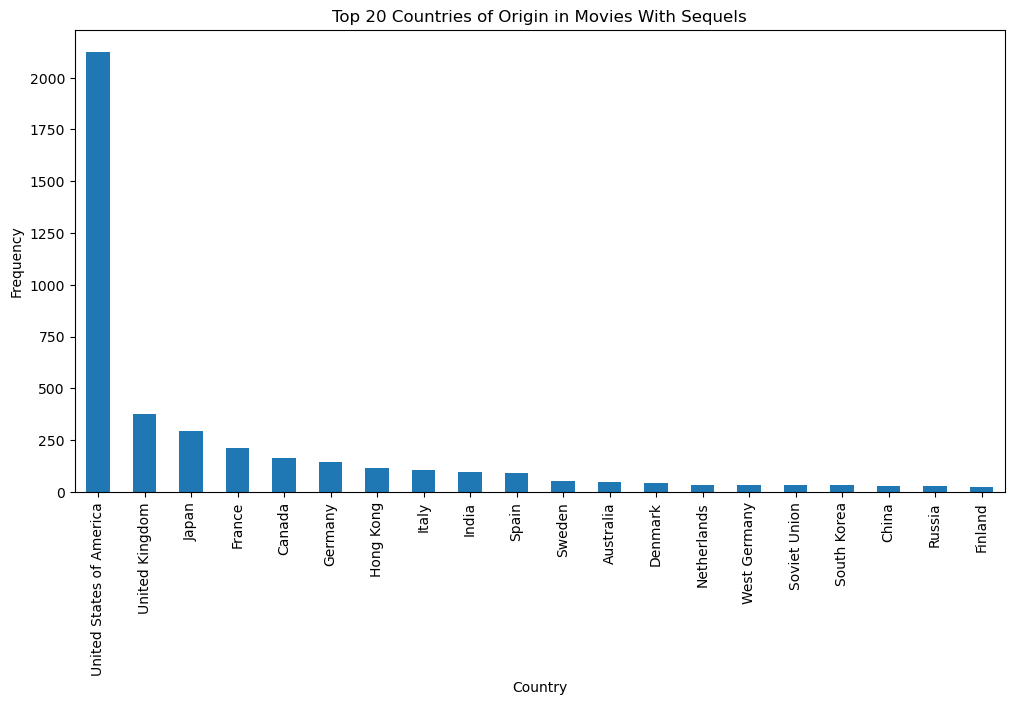

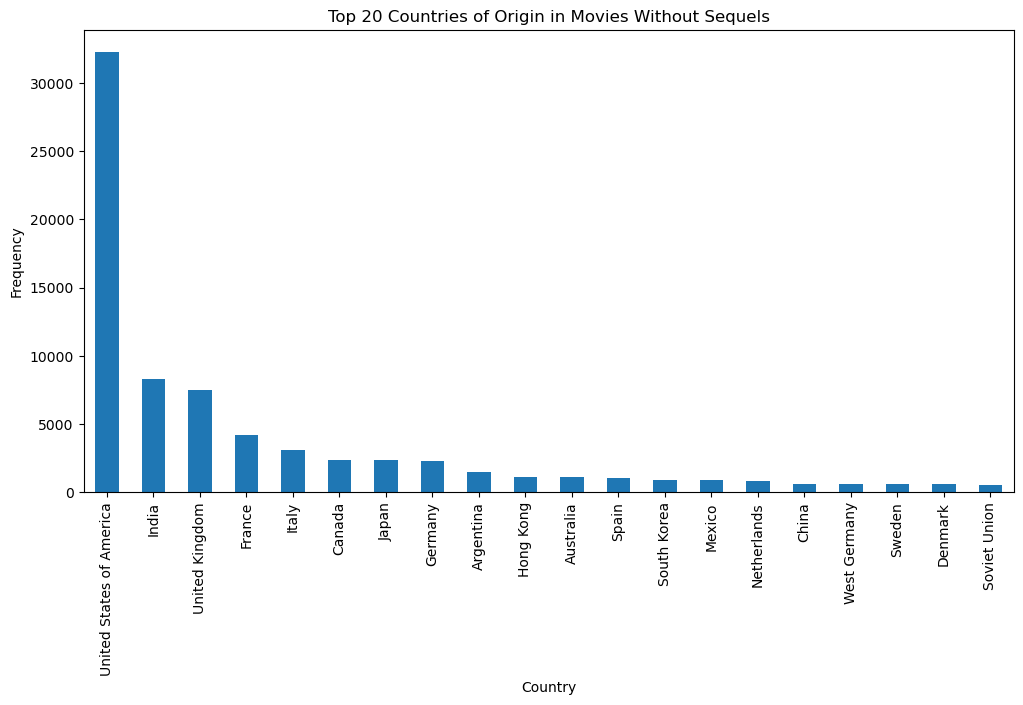

In [42]:
# Count the frequency of each country for movies with sequels
country_freq_with_sequels = with_sequels_countries['Countries'].explode().value_counts()

# Count the frequency of each country for movies without sequels
country_freq_no_sequels = no_sequels_countries['Countries'].explode().value_counts()

# Select the top 15 countries for movies with sequels
top_countries_with_sequels = country_freq_with_sequels.head(20)

# Select the top 15 countries for movies without sequels
top_countries_no_sequels = country_freq_no_sequels.head(20)

# Plot for the top 15 countries in movies with sequels
plt.figure(figsize=(12, 6))
top_countries_with_sequels.plot(kind='bar')
plt.title('Top 20 Countries of Origin in Movies With Sequels')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability

# Show the plot
plt.show()

# Plot for the top 15 countries in movies without sequels
plt.figure(figsize=(12, 6))
top_countries_no_sequels.plot(kind='bar')
plt.title('Top 20 Countries of Origin in Movies Without Sequels')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability

# Show the plot
plt.show()

What about the number of countries of origin per movie?

In [43]:
# Retrieve the countries of origin in each movie
with_sequels_countries['num_countries'] = with_sequels_countries['Countries'].apply(lambda x: len(x))
no_sequels_countries['num_countries'] = no_sequels_countries['Countries'].apply(lambda x: len(x))

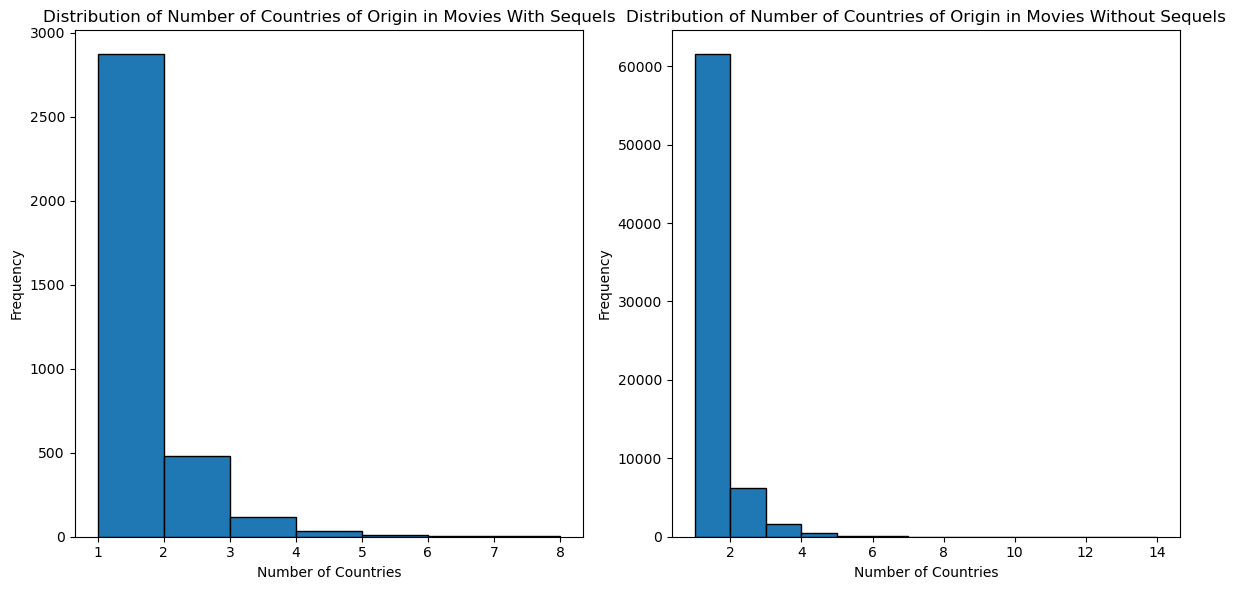

In [44]:
# Count the number of origin countries in each movie
with_sequels_countries['num_countries'] = with_sequels_countries['Countries'].apply(lambda x: len(x))
no_sequels_countries['num_countries'] = no_sequels_countries['Countries'].apply(lambda x: len(x))

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for movies with sequels
plt.subplot(1, 2, 1)
plt.hist(with_sequels_countries['num_countries'], bins=range(1, with_sequels_countries['num_countries'].max() + 1), edgecolor='black')
plt.title('Distribution of Number of Countries of Origin in Movies With Sequels')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

# Histogram for movies without sequels
plt.subplot(1, 2, 2)
plt.hist(no_sequels_countries['num_countries'], bins=range(1, no_sequels_countries['num_countries'].max() + 1), edgecolor='black')
plt.title('Distribution of Number of Countries of Origin in Movies Without Sequels')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Let's get some numbers.

In [45]:
with_sequels_countries['num_countries'].describe()

count    3837.000000
mean        1.151681
std         0.691020
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
Name: num_countries, dtype: float64

In [46]:
no_sequels_countries['num_countries'].describe()

count    77904.000000
mean         1.052834
std          0.619696
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: num_countries, dtype: float64

We can see that countries with sequels have an average number of countries of origin of 1.15, while movies with no sequels have a lower average with a mean number of countries of original equal to 1.05.
This suggests that countries with sequels tend ot have a higher number of countries of origin.

In [47]:
# test??